In [1]:
%cd ../..

/home/denis/code/study/ComputerVisionTasks


In [2]:
from models_implementation.convnext.model import ConvNeXt
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random
import matplotlib.pyplot as plt
from functools import partial
from fastai.vision.all import (top_k_accuracy,
                               accuracy,
                               F1Score,
                               Precision,
                               Recall,
                               DataLoaders,
                               CrossEntropyLossFlat,
                               EarlyStoppingCallback,
                               MixUp,
                               Learner)

/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [3]:
img_H = img_W = 224

In [4]:
metrics_list = [
    accuracy,
    partial(top_k_accuracy, k=3),
    partial(top_k_accuracy, k=5),
    F1Score(average='macro'),
    Precision(average='macro'),
    Recall(average='macro')
]

In [5]:
def show_random_images(dataset, num_images=10, denormalize=True, 
                       mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Отображает случайные изображения из датасета с их классами.

    Параметры:
      dataset: датасет, возвращающий кортеж (image, label), где image - тензор в формате (C, H, W)
      num_images: количество случайных изображений для отображения
      denormalize: если True, денормализует изображение (требует, чтобы Normalize использовался с указанными mean и std)
      mean, std: параметры нормализации, применяемые к датасету
    """
    indices = random.sample(range(len(dataset)), num_images)

    n_cols = 5
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axs = axs.flatten()
    else:
        axs = [ax for row in axs for ax in row]

    for ax, idx in zip(axs, indices):
        image, label = dataset[idx]
        if denormalize:
            image_denorm = image.clone()
            for t, m, s in zip(image_denorm, mean, std):
                t.mul_(s).add_(m)
            image_denorm = image_denorm.clamp(0, 1)
        else:
            image_denorm = image

        image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    for ax in axs[len(indices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [6]:
p = 0.2
train_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Rotate(limit=(0, 90), p=p),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=p),  # случайный поворот на кратные 90 градусов
    A.Transpose(p=p),       # случайная транспозиция
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=p),
    # Убираем нераспознаваемые аргументы:
    A.GaussNoise(p=p),                # добавление гауссовского шума
    A.RandomFog(p=p),                 # имитация облаков/тумана
    A.RandomSunFlare(p=p),            # эффект блика или солнечного сияния
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), p=p),
    A.CoarseDropout(p=p),             # случайное "вытирание" небольших участков
    A.ElasticTransform(p=p),          # эластичное искажение изображения
    # Вместо height и width передаём size
    A.RandomResizedCrop(size=(img_H, img_W), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=p),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

valid_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def transform_train(pil_image):
    image_np = np.array(pil_image)
    augmented = train_album(image=image_np)
    return augmented['image']

def transform_valid(pil_image):
    image_np = np.array(pil_image)
    augmented = valid_album(image=image_np)
    return augmented['image']

In [7]:
train_ds, valid_ds, test_ds = ImageFolder(root='./data/PatternNet/train', transform=transform_train),\
                              ImageFolder(root='./data/PatternNet/validation', transform=transform_valid),\
                              ImageFolder(root='./data/PatternNet/test', transform=transform_valid)

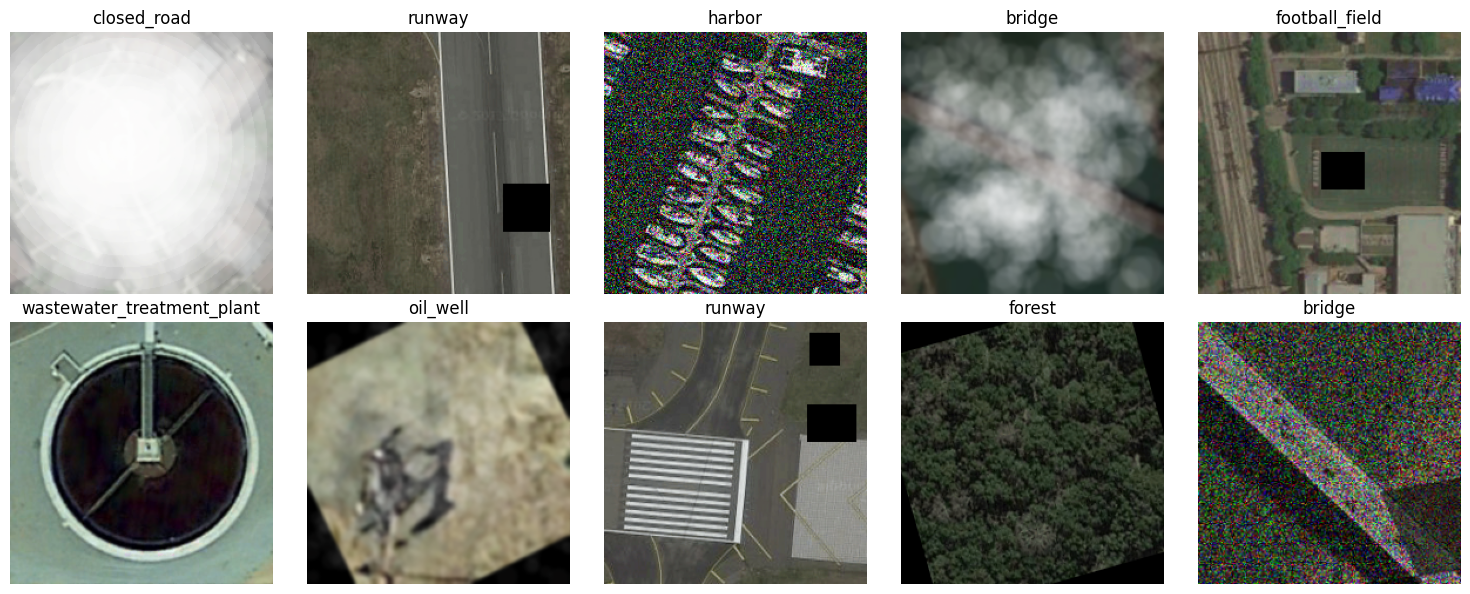

In [8]:
# Отобразить 10 случайных изображений:
show_random_images(train_ds, num_images=10)

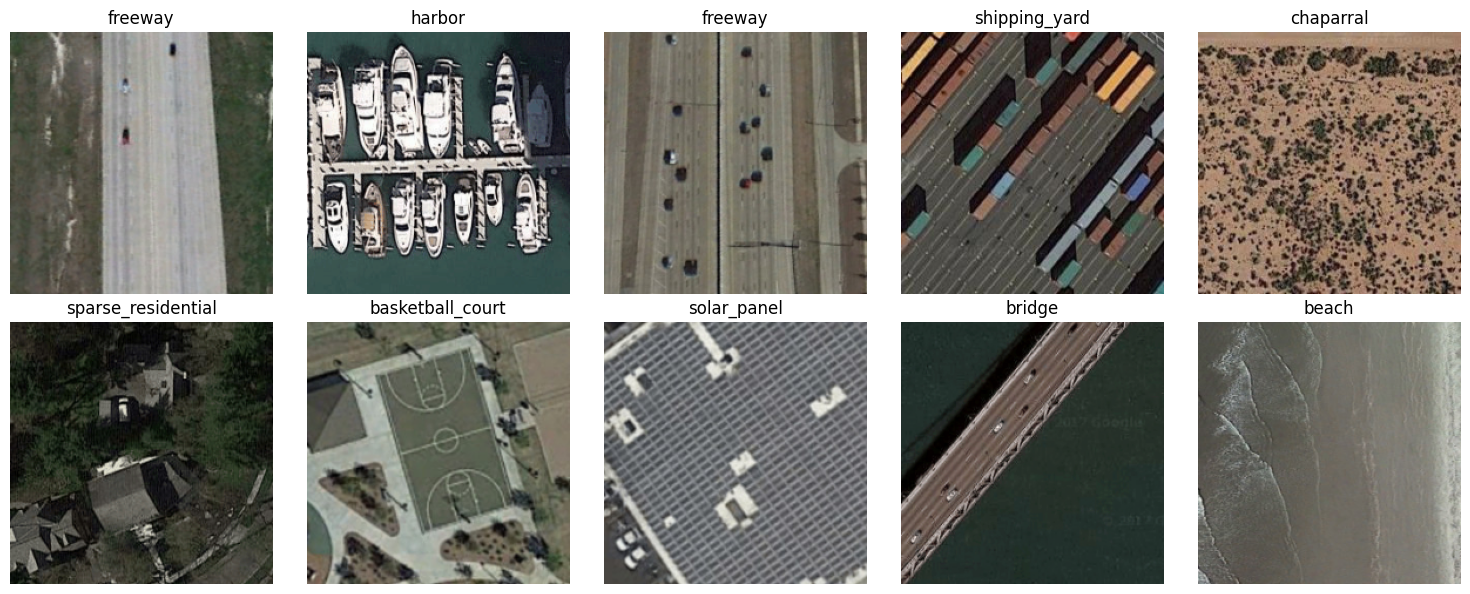

In [9]:
# Отобразить 10 случайных изображений:
show_random_images(valid_ds, num_images=10)

In [10]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, test_ds, bs=8, num_workers=0)
dls = dls.cuda()

In [11]:
# Сверточная модель: Convnext
conv_model = ConvNeXt(128, len(train_ds.classes))
conv_model.to("cuda")

ConvNeXt(
  (features): Conv2dNormActivation(
    (block): Sequential(
      (0): NamedModule(
        (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (1): NamedModule(
        (module): LayerNorm2d_first(
          (ln): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
  )
  (stage1): Sequential(
    (0): CNBlock(
      (block): Sequential(
        (0): NamedModule(
          (module): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        )
        (1): NamedModule(
          (module): Permute()
        )
        (2): NamedModule(
          (module): LayerNorm2d_block(
            (ln): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          )
        )
        (3): NamedModule(
          (module): Linear(in_features=128, out_features=512, bias=True)
        )
        (4): NamedModule(
          (module): GELU(approximate='none')
        )
        (5): NamedModule(
          (module): Line

In [12]:
loss_func = CrossEntropyLossFlat(label_smoothing=0.1)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=2)
mixup_cb = MixUp()

In [13]:
learn = Learner(dls, conv_model, loss_func=loss_func, metrics=metrics_list, 
                cbs=[early_stop_cb, mixup_cb])

In [14]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time


In [ ]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")